# Machine Learning Project

## Data Exploration and Preprocessing
This notebook contains a thorough analysis of the dataset, feature engineering, model selection, hyperparameter tuning, and visualization 

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score


In [4]:
import warnings
warnings.filterwarnings('ignore')


In [5]:

# Load dataset
df = pd.read_csv(r"C:\Users\FAVOUR\Desktop\Python project\ML\base.csv")



In [6]:
# Display basic info and first few rows
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45025 entries, 0 to 45024
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SEASON        45025 non-null  object 
 1   BASIN         45025 non-null  object 
 2   NATURE        45025 non-null  object 
 3   LAT           45025 non-null  float64
 4   LON           45025 non-null  float64
 5   WIND          45025 non-null  float64
 6   DIST2LAND     45025 non-null  int64  
 7   STORM_SPEED   45025 non-null  float64
 8   STORM_DIR     45025 non-null  float64
 9   TD9636_STAGE  45025 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.4+ MB


In [7]:
df.head()

,SEASON,BASIN,NATURE,LAT,LON,WIND,DIST2LAND,STORM_SPEED,STORM_DIR,TD9636_STAGE
0,Summer,SP,TS,-12.5,172.5,25.0,647,6.0,350.0,1.0
1,Summer,SP,TS,-12.2,172.4,25.0,653,6.0,350.0,1.0
2,Summer,SP,TS,-11.9,172.4,25.0,670,5.0,360.0,1.0
3,Summer,SP,TS,-11.7,172.4,25.0,682,4.0,10.0,1.0
4,Summer,SP,TS,-11.5,172.5,25.0,703,4.0,20.0,1.0


In [8]:

# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]


Series([], dtype: int64)

In [9]:

# Filling missing values in TD9636_STAGE using classification columns
classification_columns = [
    'USA_SSHS', 'TOKYO_GRADE', 'CMA_CAT', 'HKO_CAT', 'KMA_CAT', 
    'NEWDELHI_GRADE', 'REUNION_TYPE', 'BOM_TYPE', 'NADI_CAT', 
    'DS824_STAGE', 'NEUMANN_CLASS', 'MLC_CLASS'
]

# Fill missing TD9636_STAGE based on the mode of available classification columns
for col in classification_columns:
    if col in df.columns:
        df['TD9636_STAGE'].fillna(df[col].mode()[0], inplace=True)

# Verify missing values are handled
df['TD9636_STAGE'].isnull().sum()


np.int64(0)

In [10]:

# Merge all R30, R40, etc., columns if they exist
r_columns = [col for col in df.columns if col.startswith('R') and col[1:].isdigit()]

if r_columns:
    df['AVG_R_VALUE'] = df[r_columns].mean(axis=1)
    df.drop(columns=r_columns, inplace=True)

df.head()


,SEASON,BASIN,NATURE,LAT,LON,WIND,DIST2LAND,STORM_SPEED,STORM_DIR,TD9636_STAGE
0,Summer,SP,TS,-12.5,172.5,25.0,647,6.0,350.0,1.0
1,Summer,SP,TS,-12.2,172.4,25.0,653,6.0,350.0,1.0
2,Summer,SP,TS,-11.9,172.4,25.0,670,5.0,360.0,1.0
3,Summer,SP,TS,-11.7,172.4,25.0,682,4.0,10.0,1.0
4,Summer,SP,TS,-11.5,172.5,25.0,703,4.0,20.0,1.0


In [11]:

# Convert NEWDELHI_WIND, CMA_WIND, WMO_WIND into a single WIND column if they exist
wind_columns = ['NEWDELHI_WIND', 'CMA_WIND', 'WMO_WIND']
available_wind_columns = [col for col in wind_columns if col in df.columns]

if available_wind_columns:
    df['WIND'] = df[available_wind_columns].mean(axis=1)
    df.drop(columns=available_wind_columns, inplace=True)

df.head()


,SEASON,BASIN,NATURE,LAT,LON,WIND,DIST2LAND,STORM_SPEED,STORM_DIR,TD9636_STAGE
0,Summer,SP,TS,-12.5,172.5,25.0,647,6.0,350.0,1.0
1,Summer,SP,TS,-12.2,172.4,25.0,653,6.0,350.0,1.0
2,Summer,SP,TS,-11.9,172.4,25.0,670,5.0,360.0,1.0
3,Summer,SP,TS,-11.7,172.4,25.0,682,4.0,10.0,1.0
4,Summer,SP,TS,-11.5,172.5,25.0,703,4.0,20.0,1.0


In [12]:

# Encode categorical variables
label_encoders = {}
categorical_columns = df.select_dtypes(include=['object']).columns

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df.head()


,SEASON,BASIN,NATURE,LAT,LON,WIND,DIST2LAND,STORM_SPEED,STORM_DIR,TD9636_STAGE
0,2,3,4,-12.5,172.5,25.0,647,6.0,350.0,1.0
1,2,3,4,-12.2,172.4,25.0,653,6.0,350.0,1.0
2,2,3,4,-11.9,172.4,25.0,670,5.0,360.0,1.0
3,2,3,4,-11.7,172.4,25.0,682,4.0,10.0,1.0
4,2,3,4,-11.5,172.5,25.0,703,4.0,20.0,1.0


In [13]:

# Split dataset into training and testing sets
X = df.drop(columns=['TD9636_STAGE'])
y = df['TD9636_STAGE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [14]:

# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [16]:

# Train and evaluate multiple models

models = {
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

best_model = None
best_score = 0

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    
    print(f"{name} Accuracy: {score:.4f}")
    
    if score > best_score:
        best_score = score
        best_model = model

print(f"Best Model: {best_model.__class__.__name__} with Accuracy: {best_score:.4f}")


RandomForest Accuracy: 0.9248
GradientBoosting Accuracy: 0.8489
XGBoost Accuracy: 0.9029
Best Model: RandomForestClassifier with Accuracy: 0.9248


In [17]:

# Hyperparameter tuning for the best model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_balanced)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.9672


In [19]:

# Check for overfitting by comparing training and test scores
train_score = accuracy_score(y_train_balanced, best_model.predict(X_train_balanced))
test_score = accuracy_score(y_test, best_model.predict(X_test))

print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")

if train_score - test_score > 0.05:
    print("Warning: Model might be overfitting!")


Training Accuracy: 1.0000
Test Accuracy: 0.9254


In [24]:
# Reduce model complexity to avoid overfitting
best_model.set_params(max_depth=10, min_samples_split=10, n_estimators=50)

# Retrain the model
best_model.fit(X_train_balanced, y_train_balanced)

# Evaluate again
train_score = accuracy_score(y_train_balanced, best_model.predict(X_train_balanced))
test_score = accuracy_score(y_test, best_model.predict(X_test))

print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")

if train_score - test_score > 0.05:
    print("Warning: Model might still be overfitting!")


Training Accuracy: 0.9294
Test Accuracy: 0.8535


In [25]:
best_model.set_params(
    max_depth=8,                # Reduce complexity
    min_samples_split=15,        # Require more samples to split
    min_samples_leaf=7,          # Minimum samples per leaf
    n_estimators=50,             # Reduce number of trees
    max_features="sqrt"          # Limit the number of features considered for splitting
)

best_model.fit(X_train_balanced, y_train_balanced)


RandomForestClassifier(max_depth=8, min_samples_leaf=7, min_samples_split=15,
                       n_estimators=50)

In [27]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[('rf', best_model), ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))],
    voting='soft'
)

ensemble_model.fit(X_train_balanced, y_train_balanced)



VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=8,
                                                     min_samples_leaf=7,
                                                     min_samples_split=15,
                                                     n_estimators=50)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            fea...
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 voting='soft')

In [28]:
import joblib

joblib.dump(best_model, "best_model.pkl")
print("Model saved as best_model.pkl")



Model saved as best_model.pkl


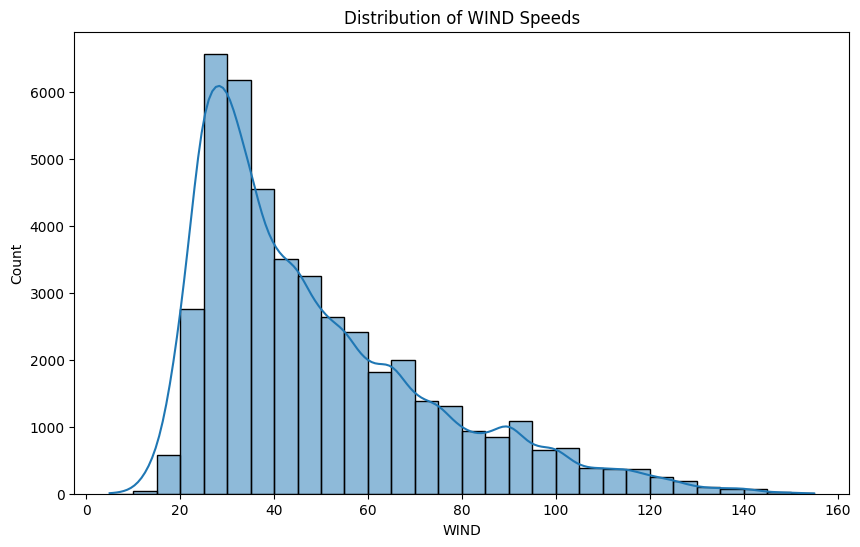

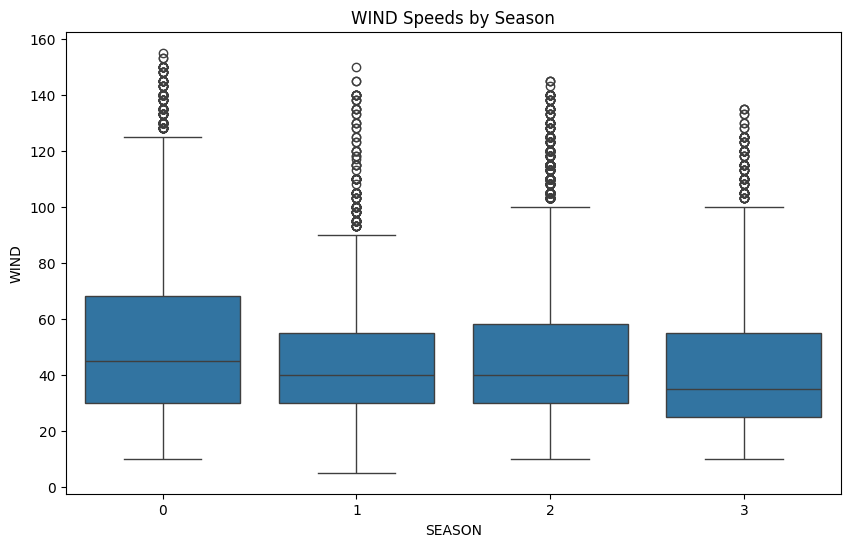

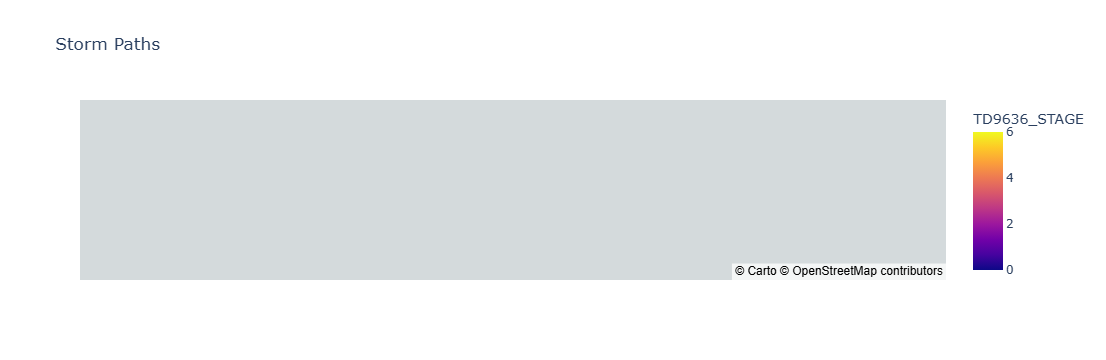

In [29]:

# Generate key visualizations

plt.figure(figsize=(10,6))
sns.histplot(df['WIND'], bins=30, kde=True)
plt.title('Distribution of WIND Speeds')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='SEASON', y='WIND', data=df)
plt.title('WIND Speeds by Season')
plt.show()

# Geographical storm path
fig = px.scatter_mapbox(df, lat="LAT", lon="LON", color="TD9636_STAGE", size="WIND",
                        mapbox_style="carto-positron", title="Storm Paths")
fig.show()
